In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.special as sc
import copy


import sys
sys.path.append('../Modules')
import Image_Fits_Stats
import Visual_analysis
import COSMOS_preprocessing_utils as utils
import matplotlib as mpl

In [14]:
df=pd.read_csv('../Data/Labels_0_50932.csv',index_col=0)
galaxies=np.load('../Data/Images_0_50932.npy')

nonunifomity=np.zeros(len(galaxies))

for i,image in enumerate(galaxies):
    image=copy.deepcopy(image)
    nonunifomity[i]=image.max()/image.mean()

df['Background_size']=df['Background_x_size']*df['Background_y_size']

#df['SNR_Power']=/np.power(df['Noise_std'],2)
#df=df[np.logical_not(np.isnan(df.Sersic_HLR))]

COSMOS_Sersic_columns=['COSMOS_Sersic_I','COSMOS_Sersic_HLR','COSMOS_Sersic_n','COSMOS_Sersic_q',
                'COSMOS_Sersic_x0','COSMOS_Sersic_y0','COSMOS_Sersic_phi']

df['PSNR']=20*np.log10(df['max_I']/df['Noise_sigma'])

df['NonUniformity']=10*np.log10(nonunifomity)

# Dataset overview

In [15]:
import Dataset_overview_filtering as overview
df.describe().iloc[1:][['PSNR', 'NonUniformity','R_cut','Background_size','COSMOS_Sersic_n','Scaling_factor']]

PSNR  NonUniformity      R_cut  Background_size  COSMOS_Sersic_n  \
mean  39.555870      12.811487  24.746904      9568.161578         1.898133   
std   10.339349       2.495328   7.674465     14212.234748         1.546292   
min   15.887755       7.128164   0.000000       136.000000         0.100000   
25%   31.813980      10.890688  18.000000      4876.000000         0.807135   
50%   37.787620      12.396428  27.000000      6612.000000         1.277303   
75%   45.553965      14.482370  32.000000      9512.000000         2.505364   
max   85.695770      29.675066  32.000000    432064.000000         6.000000   

      Scaling_factor  
mean        0.911476  
std         0.148447  
min         0.196319  
25%         0.864865  
50%         1.000000  
75%         1.000000  
max         1.000000

In [16]:
len(df)

50799

In [17]:
(df.PSNR<30).sum()

8953

In [18]:
mask_dot_like=(df.NonUniformity>=15) | (df.COSMOS_Sersic_n>=2.3) | (df.R_cut<15)
mask_dot_like.sum()

16531

In [19]:
#Very small objects that do not show any structure, hence appear to be useless
mask_dot_like=(df.NonUniformity>=15) | (df.COSMOS_Sersic_n>=2.3) | (df.R_cut<15)

#Signal-to-noise ratio filtering
mask_SNR=df.PSNR>=30

Filtering_mask=mask_SNR & ~mask_dot_like
print(Filtering_mask.sum())
Filtered_df=df[Filtering_mask]
Filtered_galaxies=galaxies[Filtering_mask]

25475


In [20]:
Filtered_df.describe()[['Ellipticity','R_cut', 'Scaling_factor',
       'Background_size', 'PSNR', 'NonUniformity']]

Ellipticity         R_cut  Scaling_factor  Background_size  \
count  25475.000000  25475.000000    25475.000000     25475.000000   
mean       0.604598     27.816801        0.886864      7611.357645   
std        0.188554      5.094121        0.164309      5550.344576   
min        0.120250     15.000000        0.223776       152.000000   
25%        0.456007     24.000000        0.800000      4896.000000   
50%        0.604528     31.000000        1.000000      6400.000000   
75%        0.755245     32.000000        1.000000      8736.000000   
max        1.000000     32.000000        1.000000    169480.000000   

               PSNR  NonUniformity  
count  25475.000000   25475.000000  
mean      37.791665      11.860345  
std        6.193848       1.483854  
min       30.001925       7.128164  
25%       33.108913      10.763885  
50%       36.367846      11.842173  
75%       40.861338      12.957977  
max       72.666477      14.999739

25475 Galaxies
PSNR [30.00,inf]


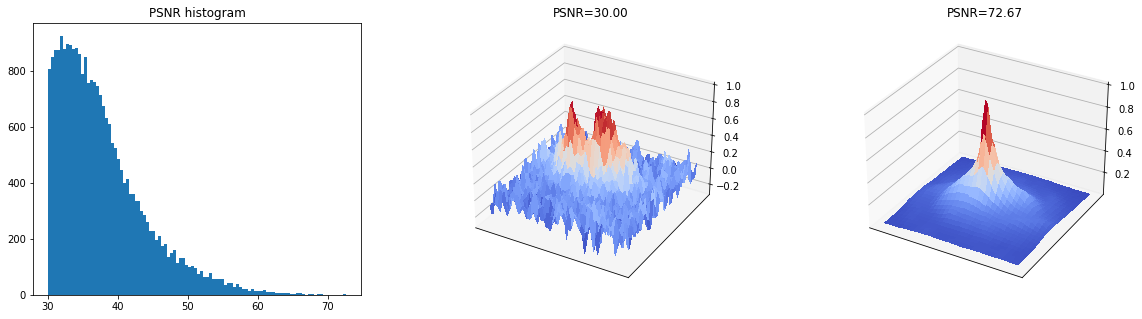

In [21]:
import Dataset_overview_filtering as overview
overview.Show_stats(galaxies,df[Filtering_mask],'PSNR',30,np.inf,3,False,False,False)

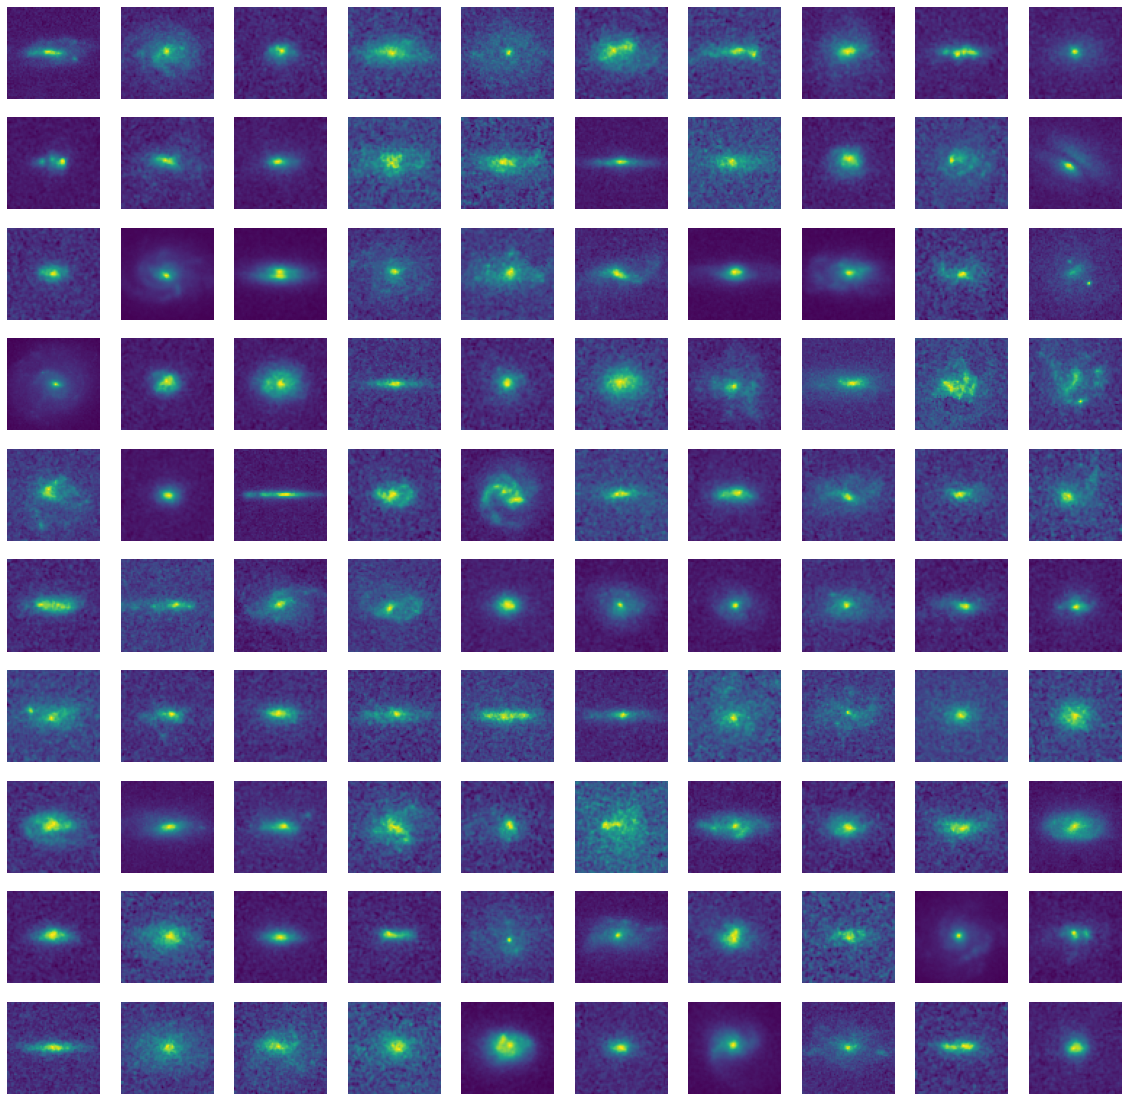

In [22]:
overview.Show_100(Filtered_galaxies,Filtered_df)

# Cutting methods

In [37]:
def get_galaxy_and_cut(index,Radial_profile_threshold=0.01):
    
    parameters=utils.create_Parametric_description(index)
    
    #Get GSObject and noise
    gal=utils.get_COSMOS_galaxy(index)
    original_image=gal.drawImage(use_true_center=True, method='auto').array

    #Extracting the parameters to build elliptical coordinates
    Sersic_fit,_=Image_Fits_Stats.fit_image(original_image,noise_std=parameters['COSMOS_noise'],exposure_time=2028)
    Ellipticity,x0,y0,Angle=Sersic_fit[-4:]
    Radial_profile=Image_Fits_Stats.Radial_profile(original_image,Ellipticity,x0,y0,Angle)

    #Getting border of galaxy from radial profile
    Radial_profile[-1]=np.nan_to_num(Radial_profile[-1])
    Radial_profile=Radial_profile-Radial_profile[-1]
    Radial_profile/=np.nanmax(Radial_profile)
    R_cut=np.where((Radial_profile<Radial_profile_threshold))[0][0]
        
    return original_image,Sersic_fit,Radial_profile,R_cut

def get_different_R_cut(Radial_profile,Radial_profile_threshold=0.01):
    Radial_R_cut=np.where((Radial_profile<Radial_profile_threshold))[0][0]
    
    increase_curve=copy.deepcopy(Radial_profile)
    increase_curve=np.nan_to_num(increase_curve)
    for i in range(1,len(Radial_profile)):
        increase_curve[i]+=increase_curve[i-1]
    increase_curve/=increase_curve[-1]
    Luminosity_R_cut=np.where((increase_curve>0.95))[0][0]
    
    return Radial_R_cut,Luminosity_R_cut,increase_curve

def plot_cuts(image,Radial_profile,Sersic_fit,border_size=1):
    img_col=np.ones((image.shape[0],image.shape[1],3))
    image=copy.deepcopy(image)
    image[image<0]=0
    for i in range(3):
        img_col[:,:,i]=image/image.max()
        
    x = np.linspace(0, image.shape[1]-1, image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    X, Y = np.meshgrid(x, y)
    I,HLR,n,Ellipticity,x0,y0,Angle=Sersic_fit
    R=np.sqrt(np.power((X-x0)*np.cos(Angle)+(Y-y0)*np.sin(Angle),2)+
        np.power((Y-y0)*np.cos(Angle)-(X-x0)*np.sin(Angle),2)/np.power(Ellipticity,2))
    mask_radial=np.where((R<(Radial_R_cut+border_size)) & (R>(Radial_R_cut-border_size)))
    mask_luminosity=np.where((R<(Luminosity_R_cut+border_size)) & (R>(Luminosity_R_cut-border_size)))
    
    for i in range(len(mask_radial[0])):
        img_col[mask_radial[0][i],mask_radial[1][i]]=mpl.colors.to_rgb('C0')
    for i in range(len(mask_luminosity[0])):
        img_col[mask_luminosity[0][i],mask_luminosity[1][i]]=mpl.colors.to_rgb('C1')
        
    return img_col

## Explanation

In [38]:
index_to_study=[10614,17269,25882,28193]

In [39]:
indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]

In [40]:
index=index_to_study[2]
_,Sersic_fit,Radial_profile,_=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

gal=utils.get_COSMOS_galaxy(index)
gal=utils.rotate_galaxy(gal,Sersic_fit[-1])
image=gal.drawImage(use_true_center=True, method='auto').array

In [41]:
_,_,_,_,COSMOS_noise_variance=utils.cat.getRealParams(index)
Sersic_fit,_=Image_Fits_Stats.fit_image(image,noise_std=np.sqrt(COSMOS_noise_variance),exposure_time=2028)

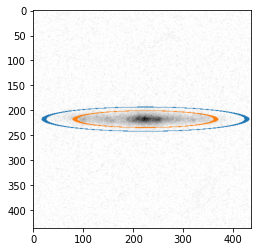

In [42]:
image_with_cuts=plot_cuts(image,Radial_profile,Sersic_fit,5)
plt.imshow(image_with_cuts)

In [47]:
image_with_cuts.shape

(436, 436, 3)

<ipython-input-51-9aee1892cb45>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([0,1])
<ipython-input-51-9aee1892cb45>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([0,1])


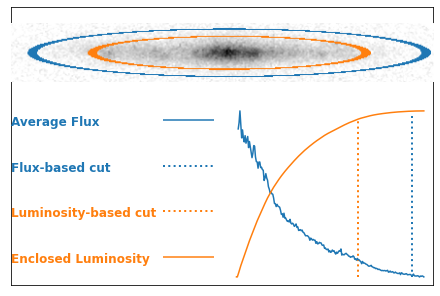

In [51]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 2,width_ratios=[1,1],
                          height_ratios=[1,1,2,2])

ax0=fig.add_subplot(gs[:, :])
ax0.set_xticks([])
ax0.set_yticks([])

image_to_show=copy.deepcopy(image_with_cuts)
image_to_show[:,0]=[]
ax1 = fig.add_subplot(gs[0:2, :])
ax1.imshow(image_with_cuts[(218-30):(218+30),:])
ax1.axis('off')
ax2 = fig.add_subplot(gs[2:, 1])


#Radial profile and Increase curve
ax2.plot(Radial_profile,label='Radial profile',color='C0')
ax2.plot(increase_curve,label='Increase curve',color='C1')
#Flux cut
ax2.vlines(Radial_R_cut,0,0.98,linestyles='dotted',color='C0',linewidth=2)
#Luminoisty cut
ax2.vlines(Luminosity_R_cut,0,0.95,linestyles='dotted',color='C1',linewidth=2)
#ax2.set_xticks([])
#ax2.set_yticks([])
ax2.axis('off')

#Labels
ax3 = fig.add_subplot(gs[2:, 0])

ax3.text(0, 0.875, 'Average Flux', color='C0',weight='bold',size=12)
ax3.hlines(0.905,0.75,1,color='C0')

ax3.text(0, 0.625, 'Flux-based cut', color='C0',weight='bold',size=12)
ax3.hlines(0.655,0.75,1,color='C0',linestyles='dotted',linewidth=2)


ax3.text(0, 0.375, 'Luminosity-based cut',weight='bold', color='C1',size=12)
ax3.hlines(0.405,0.75,1,color='C1',linestyles='dotted',linewidth=2)

ax3.text(0, 0.125, 'Enclosed Luminosity', color='C1',weight='bold',size=12)
ax3.hlines(0.155,0.75,1,color='C1')



ax3.set_xticklabels([0,1])
ax3.set_xticks([0,1])
ax3.set_yticklabels([0,1])
ax3.set_yticks([0,1])
ax3.axis('off')



#plt.savefig('Cut_explanation.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<ipython-input-270-977a5dbcd6a5>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([0,1])
<ipython-input-270-977a5dbcd6a5>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels([0,1])


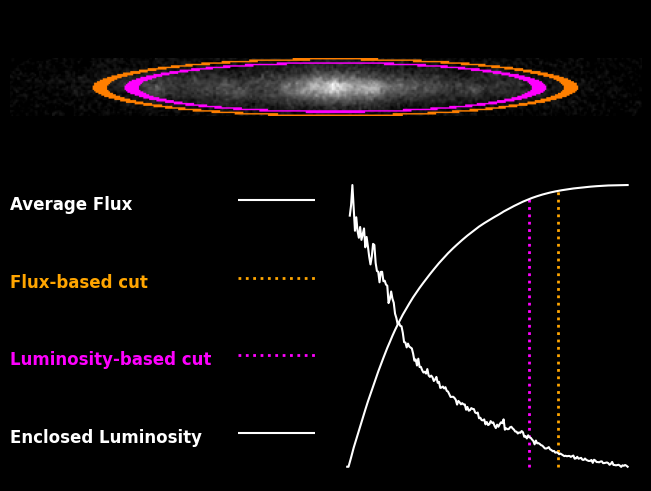

In [270]:
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 2,width_ratios=[1,1],
                          height_ratios=[1,1,2,2])

#Background
plt.style.use("dark_background")
ax0=fig.add_subplot(gs[:, :])
ax0.axis('off')

ax1 = fig.add_subplot(gs[0:2, :])
ax1.imshow(image_with_cuts[(218-20):(218+20),:],cmap='gray')
ax1.axis('off')
ax2 = fig.add_subplot(gs[2:, 1])


#Radial profile and Increase curve
ax2.plot(Radial_profile,label='Radial profile',color='white')
ax2.plot(increase_curve,label='Increase curve',color='white')
#Flux cut
ax2.vlines(Radial_R_cut,0,0.98,linestyles='dotted',color='orange',linewidth=2)
#Luminoisty cut
ax2.vlines(Luminosity_R_cut,0,0.95,linestyles='dotted',color='magenta',linewidth=2)
#ax2.set_xticks([])
#ax2.set_yticks([])
ax2.axis('off')

#Labels
ax3 = fig.add_subplot(gs[2:, 0])

ax3.text(0, 0.875, 'Average Flux', color='white',weight='bold',size=12)
ax3.hlines(0.905,0.75,1,color='white')

ax3.text(0, 0.625, 'Flux-based cut', color='orange',weight='bold',size=12)
ax3.hlines(0.655,0.75,1,color='orange',linestyles='dotted',linewidth=2)


ax3.text(0, 0.375, 'Luminosity-based cut',weight='bold', color='magenta',size=12)
ax3.hlines(0.405,0.75,1,color='magenta',linestyles='dotted',linewidth=2)

ax3.text(0, 0.125, 'Enclosed Luminosity', color='white',weight='bold',size=12)
ax3.hlines(0.155,0.75,1,color='white')



ax3.set_xticklabels([0,1])
ax3.set_xticks([0,1])
ax3.set_yticklabels([0,1])
ax3.set_yticks([0,1])
ax3.axis('off')

#plt.savefig('Cut_explanation.png')
plt.show()

In [271]:
mpl.rcParams.update(mpl.rcParamsDefault)

## Comparison

In [187]:
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(indices_to_compare[7])
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

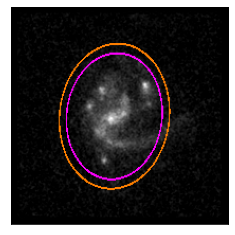

In [188]:
img_irreg=plot_cuts(image,Radial_profile,Sersic_fit,1)
plt.imshow(img_irreg)
plt.xticks([])
plt.yticks([])

In [285]:
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(1)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

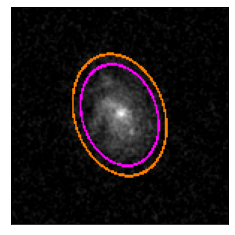

In [286]:
img_diskface=plot_cuts(image,Radial_profile,Sersic_fit,1)
plt.imshow(img_diskface)
plt.xticks([])
plt.yticks([])

In [287]:
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(index_to_study[0])
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

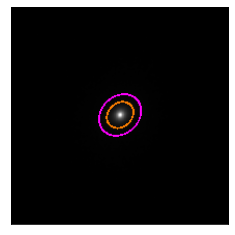

In [288]:
img_dotlike=plot_cuts(image,Radial_profile,Sersic_fit,1)
plt.imshow(img_dotlike)
plt.xticks([])
plt.yticks([])

In [289]:
image,Sersic_fit,Radial_profile,R_cut=get_galaxy_and_cut(index_to_study[2])
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

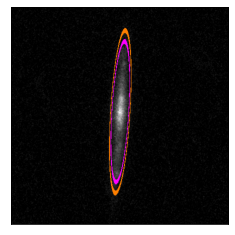

In [290]:
img_diskedge=plot_cuts(image,Radial_profile,Sersic_fit,5)
plt.imshow(img_diskedge)
plt.xticks([])
plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


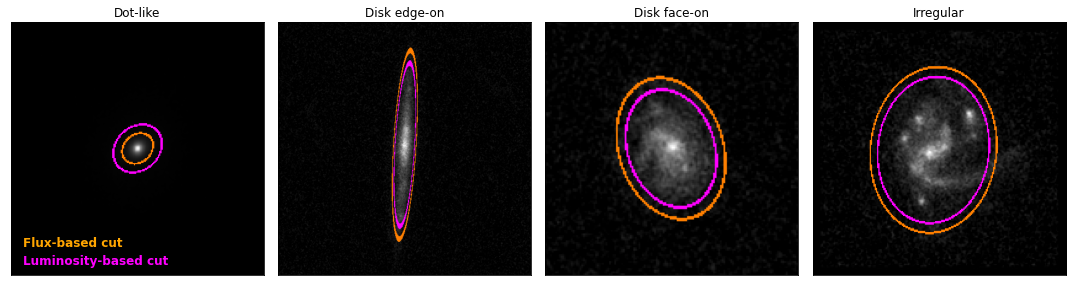

In [294]:
f, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].imshow(img_dotlike)
ax[0].text(10, 185, 'Flux-based cut', color='orange',weight='bold',size=12,bbox={'facecolor': 'black', 'pad': 5})
ax[0].text(10, 200, 'Luminosity-based cut', color='magenta',weight='bold',size=12,bbox={'facecolor': 'black', 'pad': 5})
ax[0].set_title("Dot-like")
ax[1].imshow(img_diskedge)
ax[1].set_title("Disk edge-on")
ax[2].imshow(img_diskface)
ax[2].set_title("Disk face-on")
ax[3].imshow(img_irreg)
ax[3].set_title("Irregular")
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])


plt.tight_layout()
#plt.savefig('Cut_comparison.png')
plt.show()

## Noise extraction image

In [272]:
index=0
_,Sersic_fit,Radial_profile,_=get_galaxy_and_cut(index)
Radial_R_cut,Luminosity_R_cut,increase_curve=get_different_R_cut(Radial_profile)

gal=utils.get_COSMOS_galaxy(index)
gal=utils.rotate_galaxy(gal,Sersic_fit[-1])
image=gal.drawImage(use_true_center=True, method='auto').array

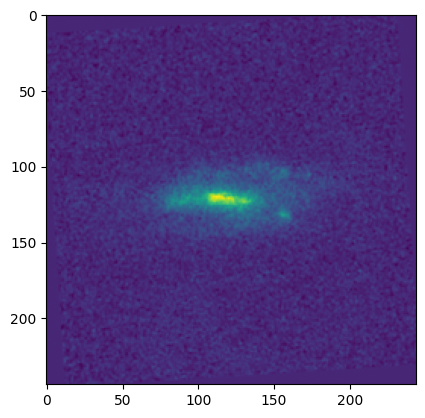

In [273]:
plt.imshow(image)

In [274]:
_,_,_,_,COSMOS_noise_variance=utils.cat.getRealParams(index)
Sersic_fit,_=Image_Fits_Stats.fit_image(image,noise_std=np.sqrt(COSMOS_noise_variance),exposure_time=2028)

In [278]:
Ellipticity,x0,y0,Angle=Sersic_fit[-4:]

In [279]:
image.shape

(244, 244)

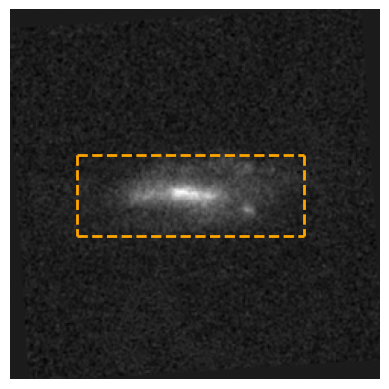

In [287]:
plt.imshow(image,cmap='gray')
plt.axis('off')
#Horizontal
plt.hlines(y0+Ellipticity*Radial_R_cut,x0-Radial_R_cut,x0+Radial_R_cut,color='orange',linestyles='dashed',linewidth=2)
plt.hlines(y0-Ellipticity*Radial_R_cut,x0-Radial_R_cut,x0+Radial_R_cut,color='orange',linestyles='dashed',linewidth=2)
#Vertical
plt.vlines(x0-Radial_R_cut,y0-Ellipticity*Radial_R_cut,y0+Ellipticity*Radial_R_cut,color='orange',linestyles='dashed',linewidth=2)
plt.vlines(x0+Radial_R_cut,y0-Ellipticity*Radial_R_cut,y0+Ellipticity*Radial_R_cut,color='orange',linestyles='dashed',linewidth=2)
plt.savefig('Image_for_bkg.png')

In [290]:
import scipy.stats as stats
1/stats.norm.ppf(0.75)

1.482602218505602

In [295]:
df['Background_size'].min()

136.0

In [296]:
df['Background_size'].median()

6612.0

# Noise thresholding cut

In [45]:
Filtered_df=Filtered_df.reset_index(drop=True)

In [29]:
x = np.linspace(0, 64-1, 64)
y = np.linspace(0, 64-1, 64)
X, Y = np.meshgrid(x, y)
x0=63/2
y0=63/2

In [31]:
threshold=1/20
Thresholded_galaxies=copy.deepcopy(Filtered_galaxies)
Ell_outlined_galaxies=copy.deepcopy(Filtered_galaxies)
for i in tqdm(range(len(Filtered_galaxies))):
    Thresholded_galaxies[i][Thresholded_galaxies[i]<threshold*Thresholded_galaxies[i].max()]=np.nan
    
    Ellipticity=Filtered_df.iloc[i].Ellipticity
    R_cut=Filtered_df.iloc[i].R_cut
    R=np.sqrt(np.power((X-x0),2)+
        np.power((Y-y0),2)/np.power(Ellipticity,2))
    Ell_outlined_galaxies[i][R>R_cut]=np.nan

100%|██████████| 25475/25475 [00:07<00:00, 3541.95it/s]


In [11]:
Thresholded_galaxies.shape

(25475, 64, 64)

In [12]:
Filtered_df.shape

(25475, 43)

PSNR 30.001925432267463
Number of galaxies 25475


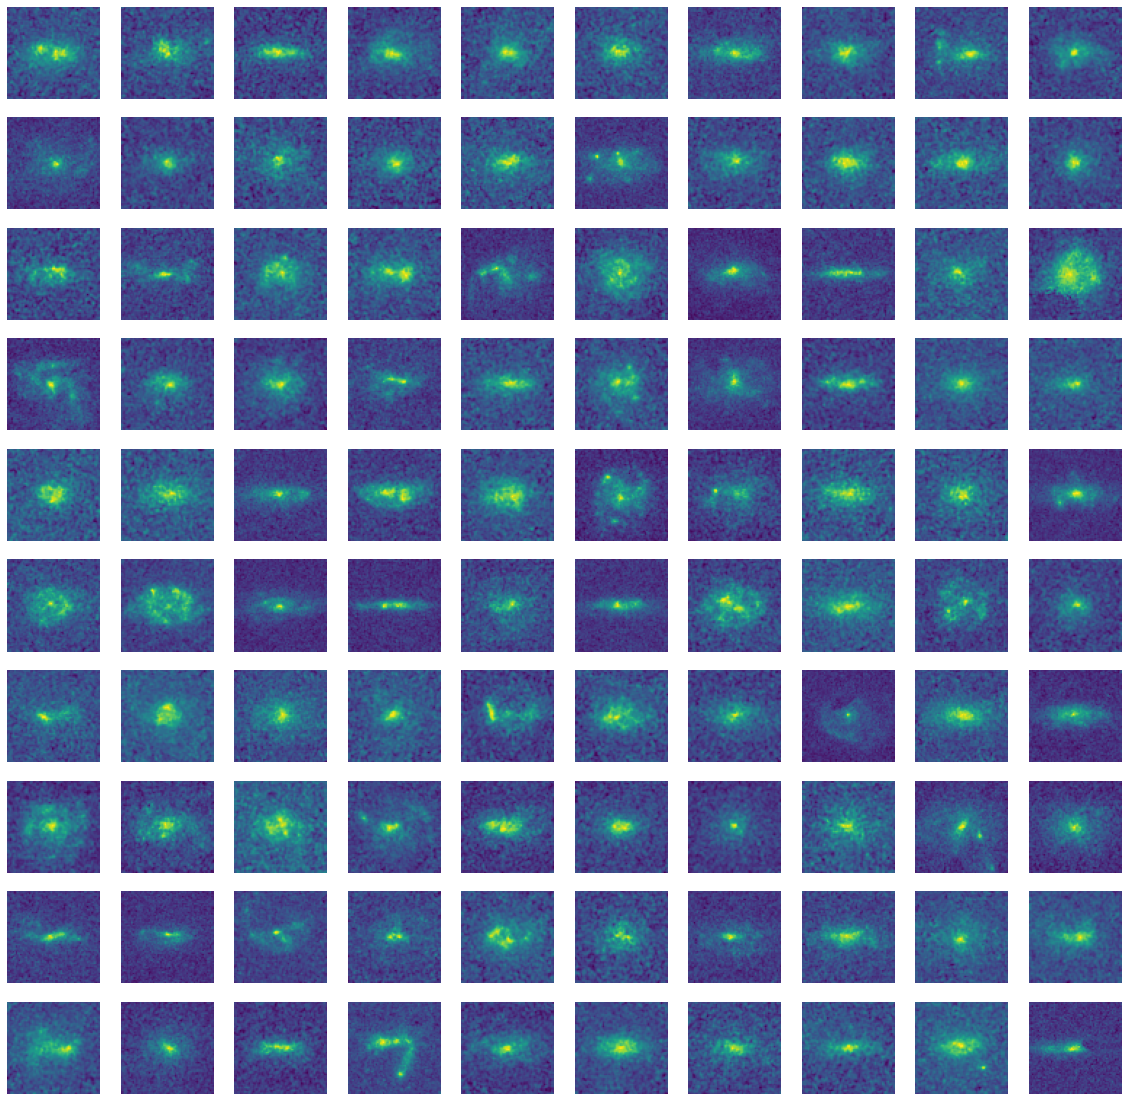

In [46]:
df_filt=overview.Show_filtered(Filtered_galaxies,Filtered_df,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

PSNR 30.001925432267463
Number of galaxies 25475


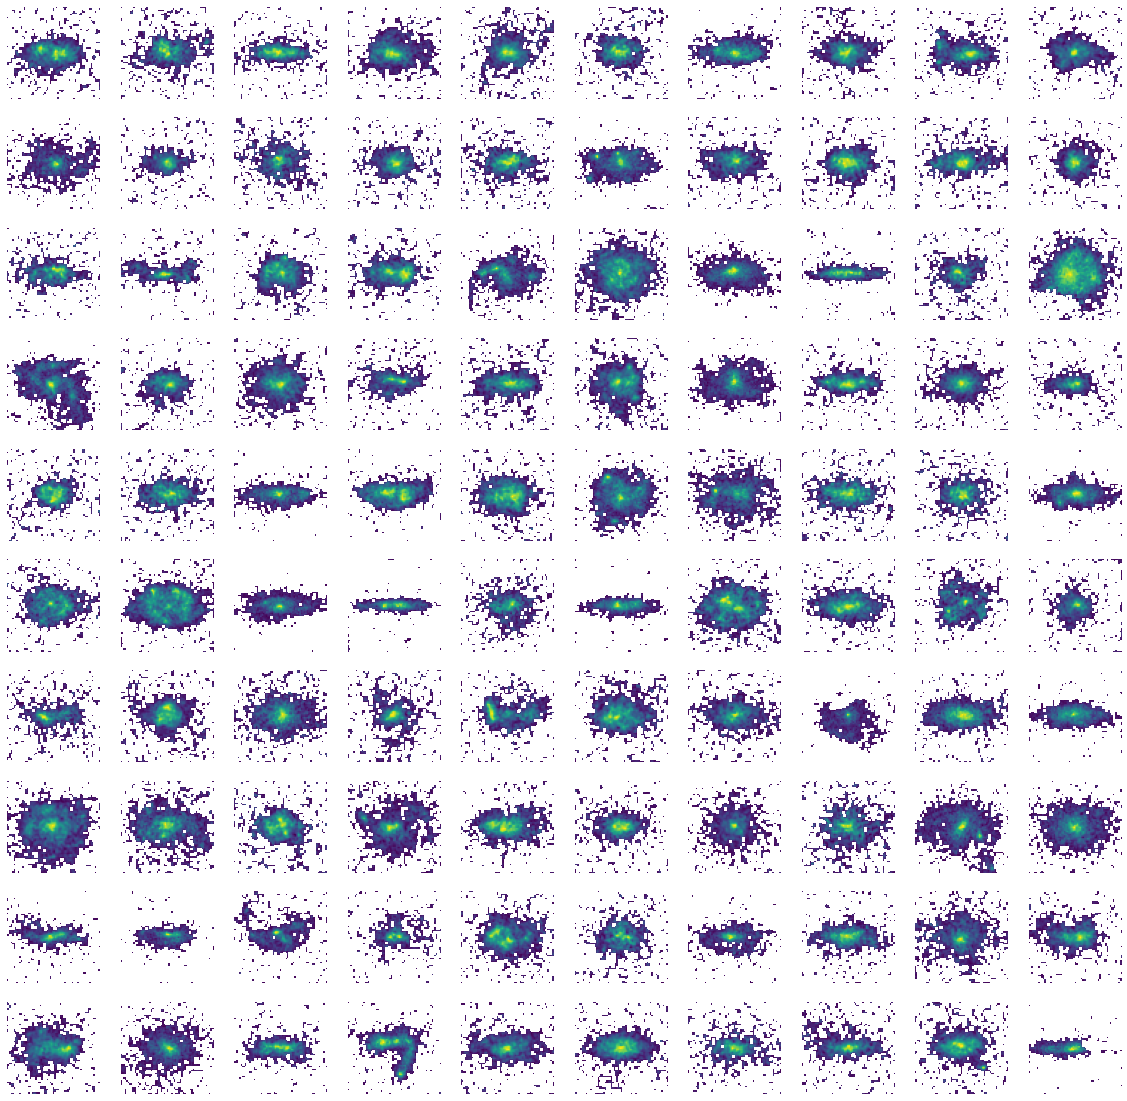

In [47]:
df_filt=overview.Show_filtered(Thresholded_galaxies,Filtered_df,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

PSNR 30.001925432267463
Number of galaxies 25475


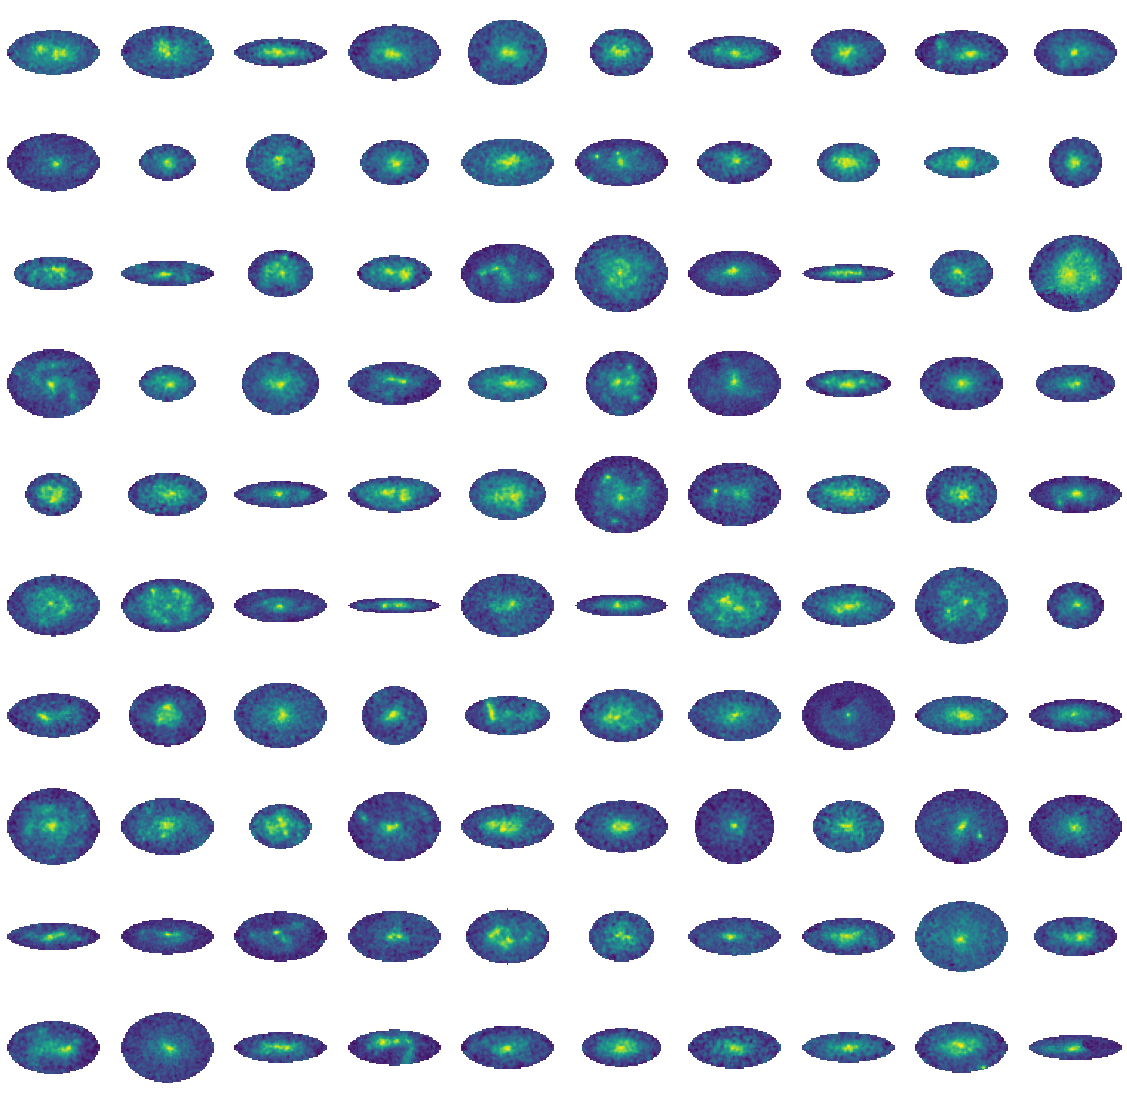

In [48]:
df_filt=overview.Show_filtered(Ell_outlined_galaxies,Filtered_df,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

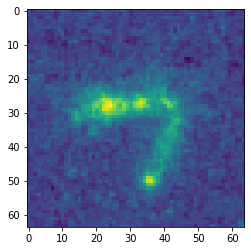

In [54]:
index=df_filt.iloc[93].name
plt.imshow(Filtered_galaxies[index])

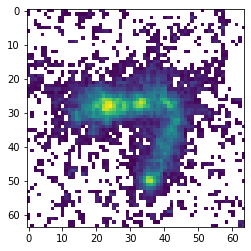

In [94]:
plt.imshow(Thresholded_galaxies[index])

In [33]:
from sklearn.cluster import KMeans

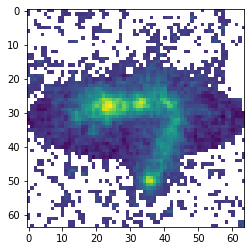

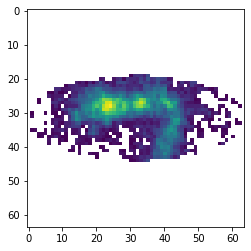

In [120]:
Unity_coords=np.where(~(np.isnan(Thresholded_galaxies[index]) & np.isnan(Ell_outlined_galaxies[index])))
Unity_points=[[Unity_coords[0][i],Unity_coords[1][i]] for i in range(len(Unity_coords[0]))]
Unity_image=copy.deepcopy(Filtered_galaxies[index])
Unity_image[np.isnan(Thresholded_galaxies[index]) & np.isnan(Ell_outlined_galaxies[index])]=np.nan
plt.imshow(Unity_image)
plt.show()

Cross_coords=np.where((~np.isnan(Thresholded_galaxies[index]) & (~np.isnan(Ell_outlined_galaxies[index]))))
Cross_points=[[Cross_coords[0][i],Cross_coords[1][i]] for i in range(len(Cross_coords[0]))]
Cross_image=copy.deepcopy(Filtered_galaxies[index])
Cross_image[np.isnan(Thresholded_galaxies[index]) | np.isnan(Ell_outlined_galaxies[index])]=np.nan
plt.imshow(Cross_image)
plt.show()


In [112]:
i=1
Cross_coords=np.where(~np.isnan(Thresholded_galaxies[index] & ~np.isnan(Ell_outlined_galaxies[index]))


[Cross_coords[0][i],Cross_coords[1][i]]

SyntaxError: unexpected EOF while parsing (<ipython-input-112-901c52dc4d90>, line 5)

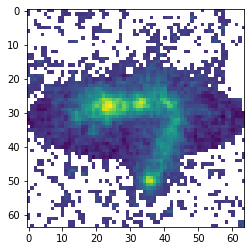

In [93]:
Unity_image=copy.deepcopy(Filtered_galaxies[index])
Unity_image[np.isnan(Thresholded_galaxies[index]) & np.isnan(Ell_outlined_galaxies[index])]=np.nan
plt.imshow(Unity_image)

In [104]:
init=(np.array([np.array([31,31]),points[0]]))

In [105]:
kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(points)

In [107]:
for i in range(9):
    print(i,len(kmeans[kmeans==i]))

0 141
1 282
2 290
3 201
4 122
5 242
6 279
7 313
8 99


In [102]:
colored_image=np.zeros((64,64,3))
for i in range(len(points)):
        x,y=points[i]
        if kmeans[i]==1:
            colored_image[x,y]=[1,0,0]
        else:
            colored_image[x,y]=[0,0,1]

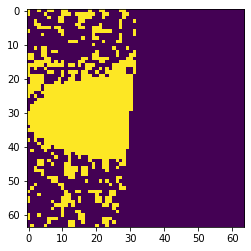

In [103]:
plt.imshow(colored_image[:,:,0])
plt.show()

In [77]:
colored_image[]

(64, 64, 3)

In [ ]:
>>> from sklearn.cluster import KMeans
>>> import numpy as np
>>> X = np.array([[1, 2], [1, 4], [1, 0],
...               [10, 2], [10, 4], [10, 0]])
>>> kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
>>> kmeans.labels_
array([1, 1, 1, 0, 0, 0], dtype=int32)
>>> kmeans.predict([[0, 0], [12, 3]])
array([1, 0], dtype=int32)
>>> kmeans.cluster_centers_
array([[10.,  2.],
       [ 1.,  2.]])

# SNR

50799 Galaxies
PSNR [0.00,inf]


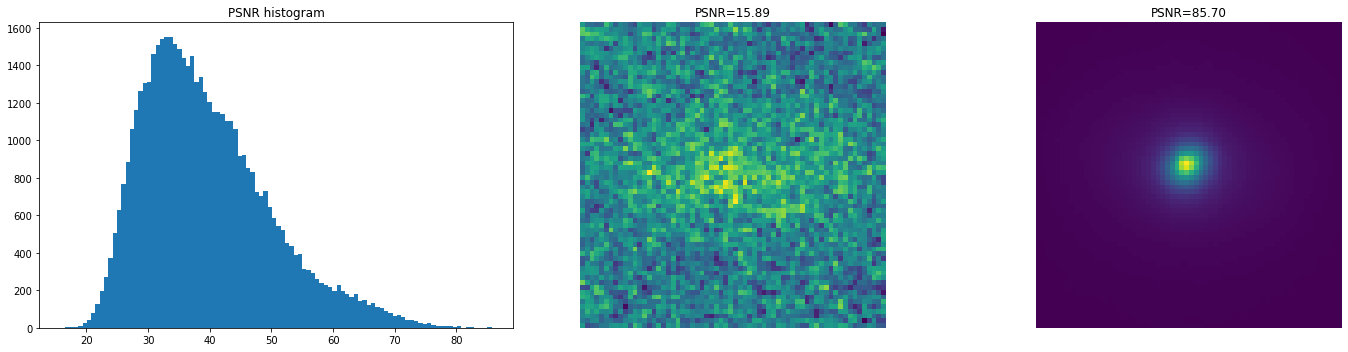

In [11]:
overview.Show_stats(galaxies,df,'PSNR',0,np.inf,2,False,False,False)

50799 Galaxies
PSNR [0.00,inf]


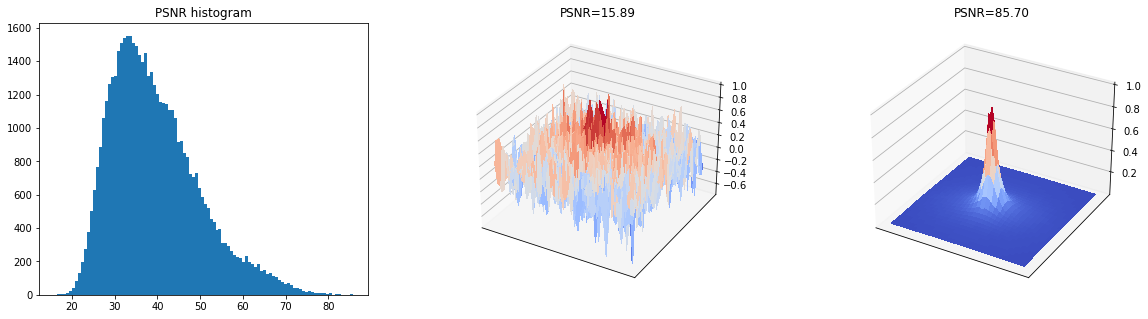

In [12]:
overview.Show_stats(galaxies,df,'PSNR',0,np.inf,3,False,False,False)

In [ ]:
over

NonUniformity 14.999739167185645
Number of galaxies 25475


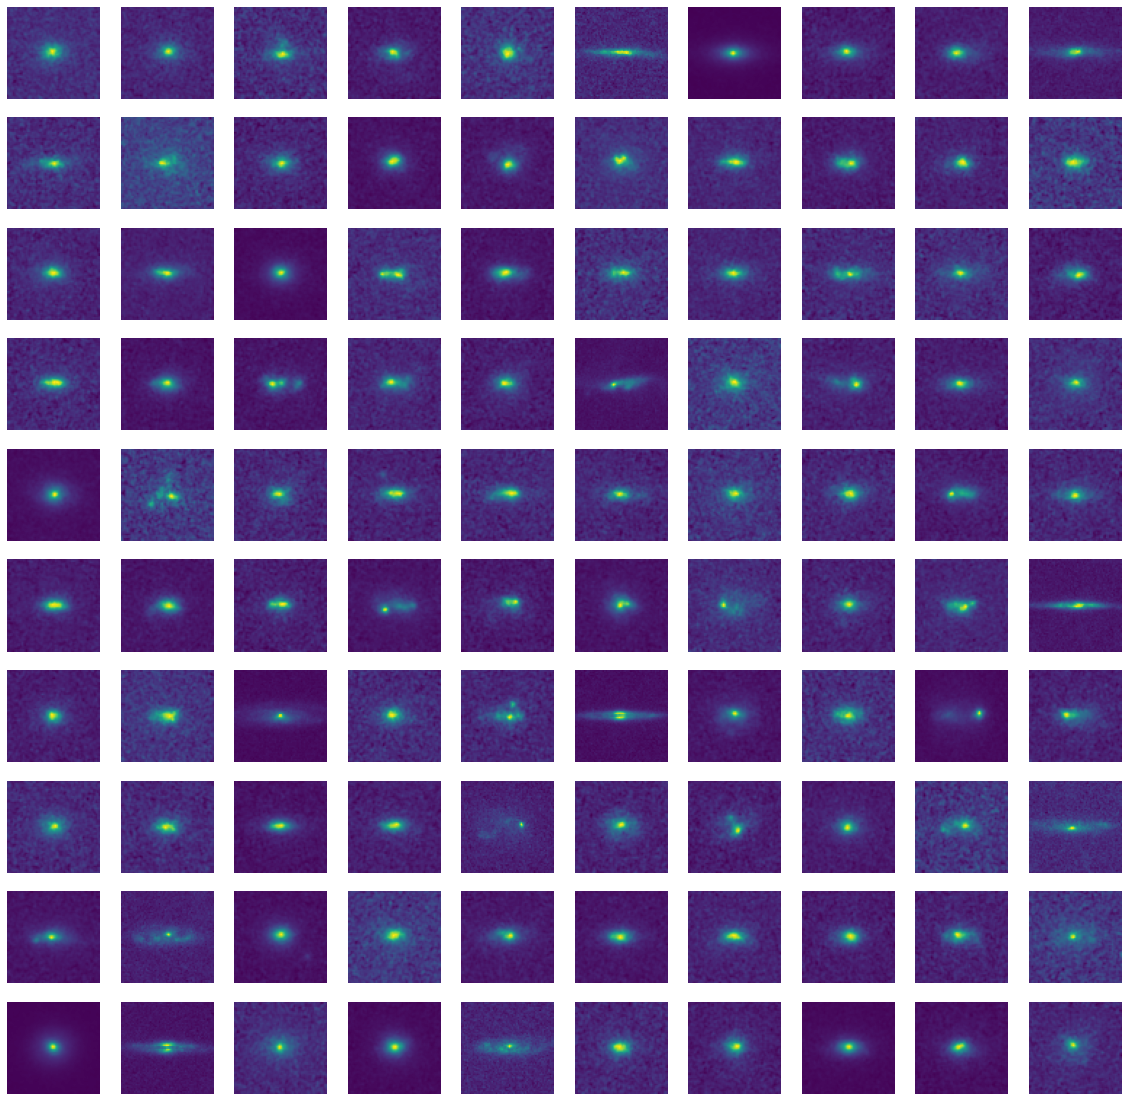

In [127]:
df_filt=overview.Show_filtered(Filtered_galaxies,Filtered_df,'NonUniformity',ascending=False,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)

PSNR 85.69576982198393
Number of galaxies 50799


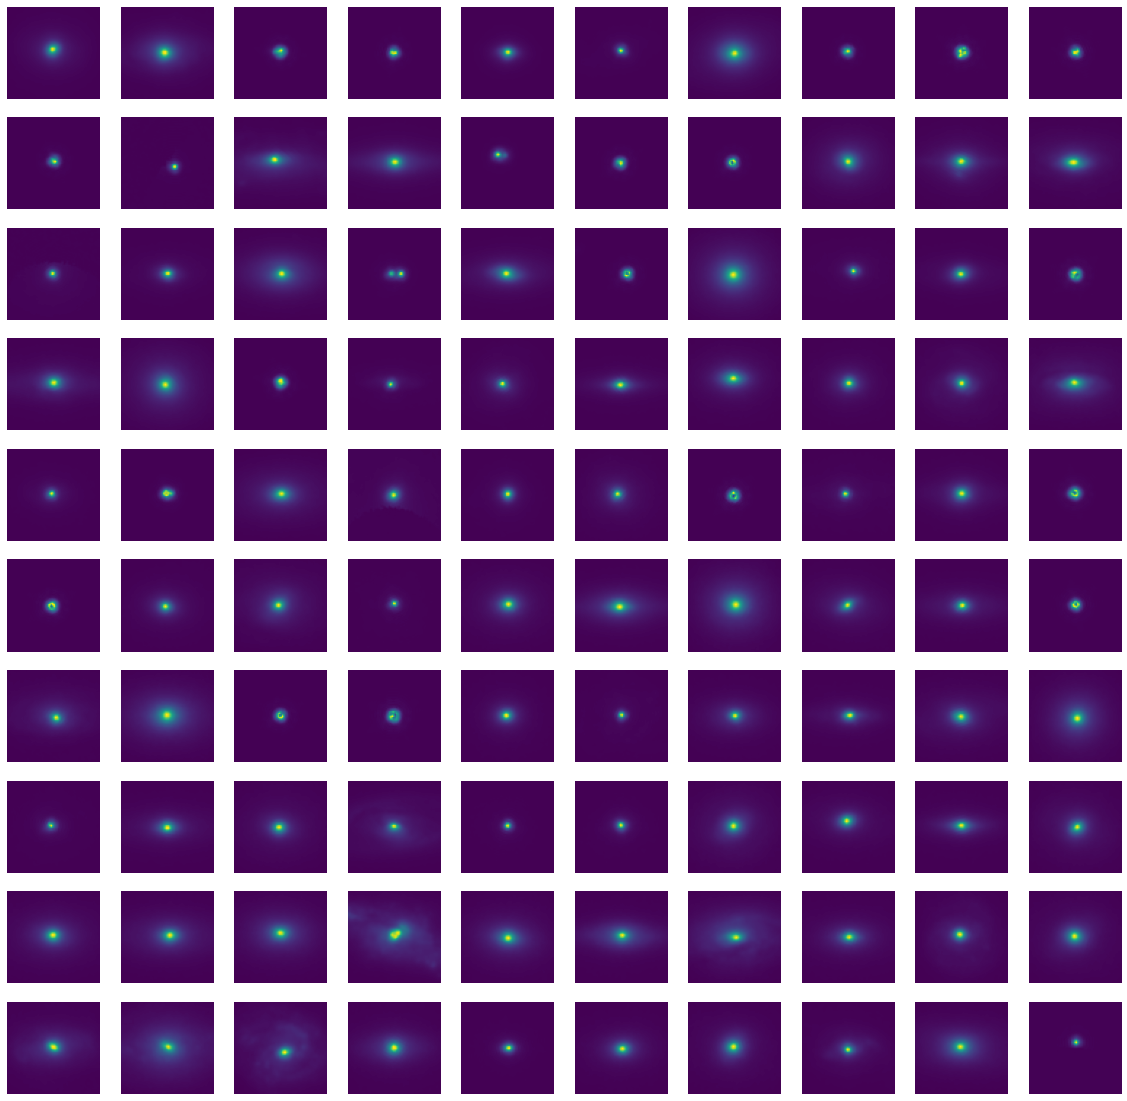

In [14]:
df_filt=overview.Show_filtered(galaxies,df,'PSNR',ascending=False,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False)